In [1]:
%matplotlib inline
import json
import numpy as np
import glob
import matplotlib.pyplot as plt
import brewer2mpl
import math
import pandas as pd
bmap = brewer2mpl.get_map('Set1', 'qualitative', 9)
colors = bmap.mpl_colors
import os

In [60]:
files = [
    '../log/local/CMCPos-v0'
]

In [61]:
frames = [] # List of pandas dataframes corresponding to each results file
to_drop = ['eval_freq', 'log_dir', 'max_steps', 'nb_test_steps', 'nb_train_iter','render_test', 'render_train', 'resume_step', 'resume_timestamp',
       'save_freq', 'train_freq', 'random_seed']
for file in files:
    # Fetching json files corresponding to one set of parameters
    runs = glob.glob(file + '/2018_03_19_18_15_27/') 
    for num_run, run in enumerate(runs):
        # Discarding runs with broken result files
        try:
            df = pd.read_json(os.path.join(run,'log_steps', 'progress.json') , lines=True)
        except ValueError:
            print("run "+run+": invalid")
        config = pd.read_json(os.path.join(run,'config.txt'), lines=True).drop(to_drop, axis=1)
        config = pd.concat([config]*df.shape[0], ignore_index=True)
        data = pd.concat([df, config], axis=1)
        data['num_run']=num_run
        frames.append(data)
# Creating the complete dataframe with all dat
expe_res_steps = pd.concat(frames, ignore_index=True)
expe_res_steps

,env_step,mean_Q_values,mean_action_grads,mean_actions_0,reward_init,reward_rnd,std_Q_values,std_action_grads,std_actions_0,training_step,...,env,gamma,invert_grads,memory,minibatch_size,sigma,strategy,target_clip,tau,num_run
0,1000,-0.124164,-0.038617,-0.025997,-0.298395,29.432326,0.031861,0.138660,0.034704,808,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0
1,2000,-0.048249,-0.035359,-0.919416,-99.021508,-59.757162,0.083551,0.032812,0.093877,1808,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0
2,3000,1.496383,0.006804,-0.253042,-48.578011,-3.978828,7.304015,0.112124,0.440130,2808,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0
3,4000,2.861554,0.033509,-0.638246,-99.872000,-57.110630,11.232063,0.190693,0.641426,3808,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0
4,5000,9.744843,0.006987,-0.396701,-99.899820,-39.958355,16.959641,0.100061,0.898779,4808,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0
5,6000,17.358198,0.007205,0.099681,-99.892741,-79.553604,19.101828,0.137523,0.989053,5808,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0
6,7000,14.333525,-0.037551,0.337321,-99.850337,-62.588909,18.805851,0.172760,0.872324,6808,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0
7,8000,12.868310,-0.042104,0.808542,-99.899930,-20.816306,16.013985,0.190445,0.335418,7808,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0
8,9000,10.059463,-0.108436,-0.138071,-88.129924,1.081063,14.651261,0.244877,0.925127,8808,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0
9,10000,10.919461,-0.047643,-0.005827,77.899430,-56.351541,15.952875,0.349539,0.950550,9808,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0


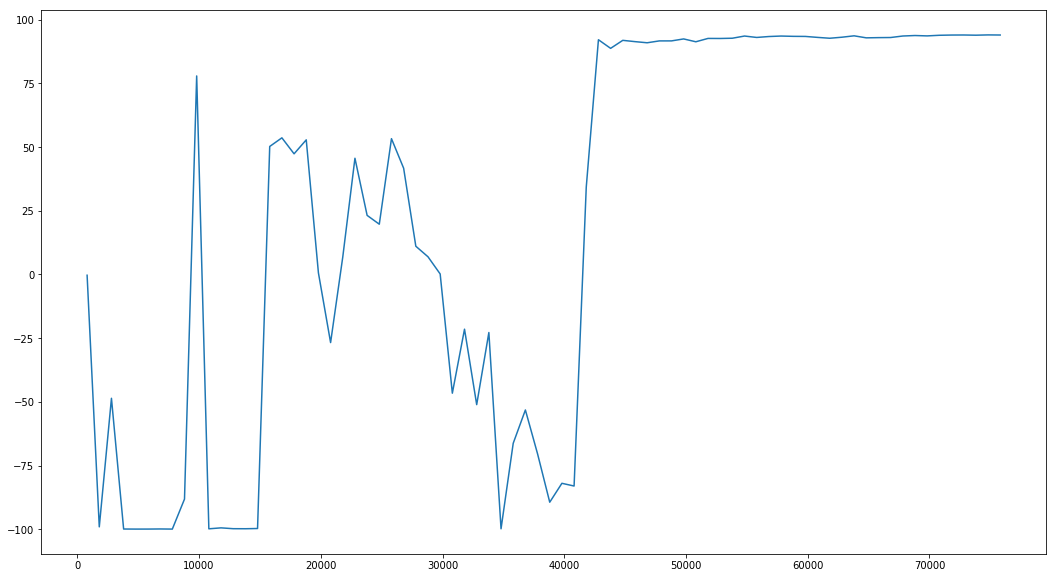

In [62]:
params = ['actor_lr', 'alpha','buffer_size', 'critic_lr', 'env', 'gamma', 'invert_grads', 'memory','minibatch_size', 'sigma', 'strategy', 'target_clip','tau']
y = ['reward_init']
x = ['training_step']
df = expe_res_steps[x+y+params]
l = x+params
df = df.groupby(l).mean().reset_index()

fig, ax = plt.subplots(figsize=(18,10))
for i, (name, g) in enumerate(df.groupby(params)):
    ax.plot(g[x], g[y])

In [44]:
frames = [] # List of pandas dataframes corresponding to each results file
for file in files:
    # Fetching json files corresponding to one set of parameters
    res_episodes = glob.glob(file + '/*/') 
    for num_run, run in enumerate(res_episodes):
        # Discarding runs with broken result files
        try:
            df = pd.read_json(os.path.join(run,'log_episodes', 'progress.json') , lines=True)
        except ValueError:
            print("run "+run+": invalid")
        config = pd.read_json(os.path.join(run,'config.txt'), lines=True).drop(to_drop, axis=1)
        config = pd.concat([config]*df.shape[0], ignore_index=True)
        data = pd.concat([df, config], axis=1)
        data['num_run']=num_run
        frames.append(data)
# Creating the complete dataframe with all dat
expe_res_episodes = pd.concat(frames, ignore_index=True)
expe_res_episodes

,Duration,Env_step,Episode,Episode_steps,Goal,Goal_reached,Start,Train_reward,Train_step,actor_lr,...,env,gamma,invert_grads,memory,minibatch_size,sigma,strategy,target_clip,tau,num_run
0,0.091200,17,1,17,"{'__ndarray__': [-0.6492878471681011], 'dtype'...",1,"{'__ndarray__': [-0.45846703927744303], 'dtype...",99.333217,0,0.0001,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0
1,0.142137,67,2,50,"{'__ndarray__': [-0.32448223442455904], 'dtype...",2,"{'__ndarray__': [-0.47679037052711104], 'dtype...",98.286948,0,0.0001,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0
2,0.159348,85,3,18,"{'__ndarray__': [-0.279138304828346], 'dtype':...",3,"{'__ndarray__': [-0.5941177154290971], 'dtype'...",98.770689,0,0.0001,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0
3,11.066440,543,4,458,"{'__ndarray__': [0.27694048860076403], 'dtype'...",4,"{'__ndarray__': [-0.481262284907491], 'dtype':...",58.808819,350,0.0001,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0
4,34.042867,1019,5,476,"{'__ndarray__': [-0.570820873055019], 'dtype':...",5,"{'__ndarray__': [-0.44935739919820006], 'dtype...",54.957485,826,0.0001,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0
5,42.391312,1279,6,260,"{'__ndarray__': [-0.7656087408258261], 'dtype'...",6,"{'__ndarray__': [-0.494337642864049], 'dtype':...",79.594106,1086,0.0001,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0
6,43.049840,1302,7,23,"{'__ndarray__': [-0.128866362231744], 'dtype':...",7,"{'__ndarray__': [-0.545527469308272], 'dtype':...",97.700000,1109,0.0001,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0
7,43.973434,1334,8,32,"{'__ndarray__': [0.016159408644478002], 'dtype...",8,"{'__ndarray__': [-0.5488004535395661], 'dtype'...",96.800000,1141,0.0001,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0
8,44.001788,1335,9,1,"{'__ndarray__': [-0.392788240857234], 'dtype':...",9,"{'__ndarray__': [-0.42024118813329503], 'dtype...",99.900000,1142,0.0001,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0
9,89.849934,2334,10,999,"{'__ndarray__': [0.19377970993474303], 'dtype'...",9,"{'__ndarray__': [-0.545746714277567], 'dtype':...",-99.799336,2141,0.0001,...,CMCPos-v0,0.99,True,sarst,64,2,final,True,0.001,0


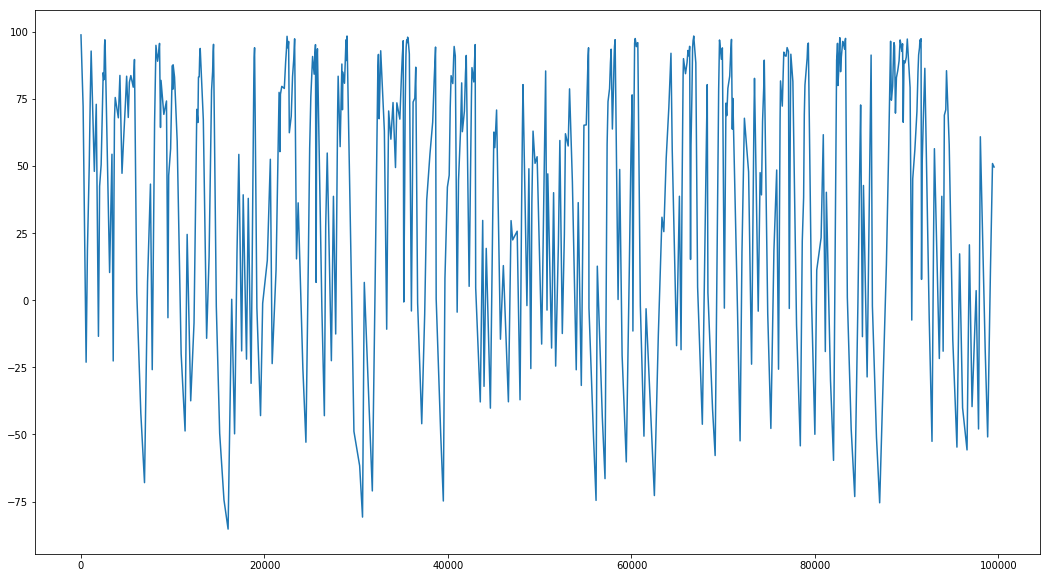

In [47]:
params = ['actor_lr', 'alpha','buffer_size', 'critic_lr', 'env', 'gamma', 'invert_grads', 'memory','minibatch_size', 'sigma', 'strategy', 'target_clip','tau']
y = ['Train_reward']
x = ['Train_step']
df = expe_res_episodes[x+y+params]
df = df.groupby(x+params).mean().reset_index()
df = df.groupby(params).apply(lambda s: s.ewm(1).mean()).reset_index()


fig, ax = plt.subplots(figsize=(18,10))
for i, (name, g) in enumerate(df.groupby(params)):
    ax.plot(g[x], g[y])

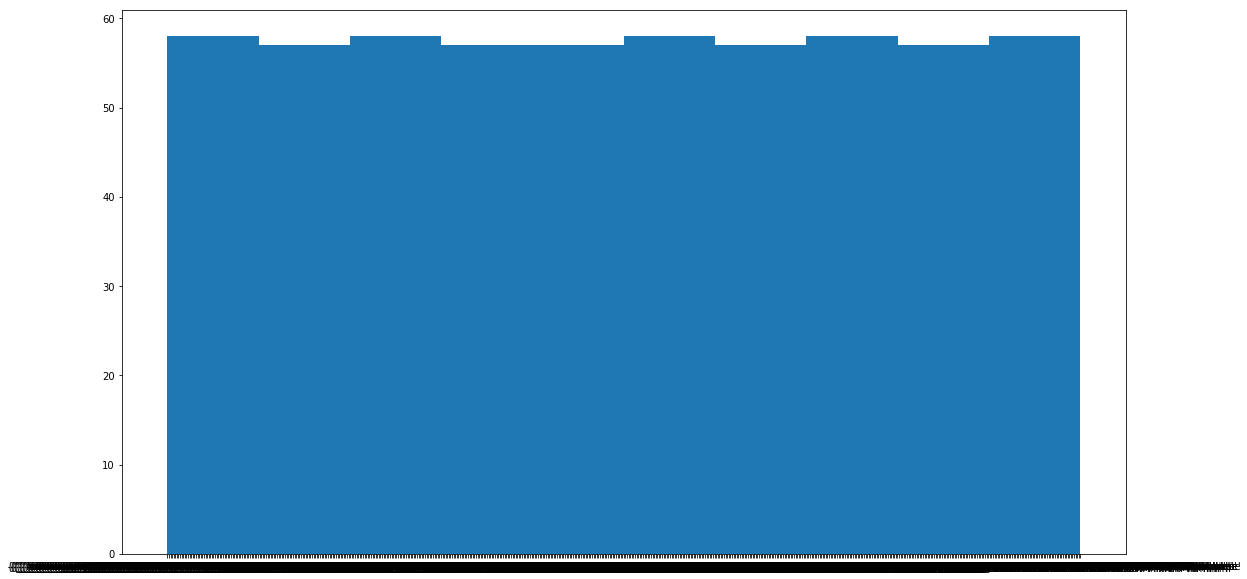

In [55]:
params = ['actor_lr', 'alpha','buffer_size', 'critic_lr', 'env', 'gamma', 'invert_grads', 'memory','minibatch_size', 'sigma', 'strategy', 'target_clip','tau']
y = ['Goal']
x = ['Train_step']
df = expe_res_episodes[x+y+params]
# df = df.groupby(x+params).mean().reset_index()
# df = df.groupby(params).apply(lambda s: s.ewm(1).mean()).reset_index()
df['Goal'].apply(lambda x: x['__ndarray__'][0])
df

fig, ax = plt.subplots(figsize=(18,10))
for i, (name, g) in enumerate(df.groupby(params)):
    ax.hist(g[y])

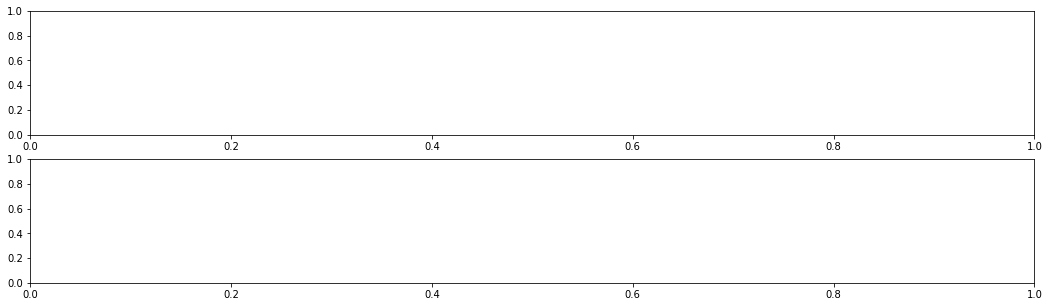

In [27]:
# Only keeping lines corresponding to the evaluation at training step N
N = 199000
res_final = expe_res_steps[expe_res_steps['training_step']==N]

# For each set of parameters, plot the histogram of performances on the initial goal at step N over the different runs
fig, axes = plt.subplots(2,1, figsize=(18,5))
for i,(name, g) in enumerate(res_final.groupby('params')['Test reward on initial goal']):
    axes[i].hist(g)
    axes[i].set_title(name)
    axes[i].set_xlabel('Final accumulated reward', fontsize=18)
    axes[i].set_ylabel('Number of runs', fontsize=18)


(-5000, 200000)

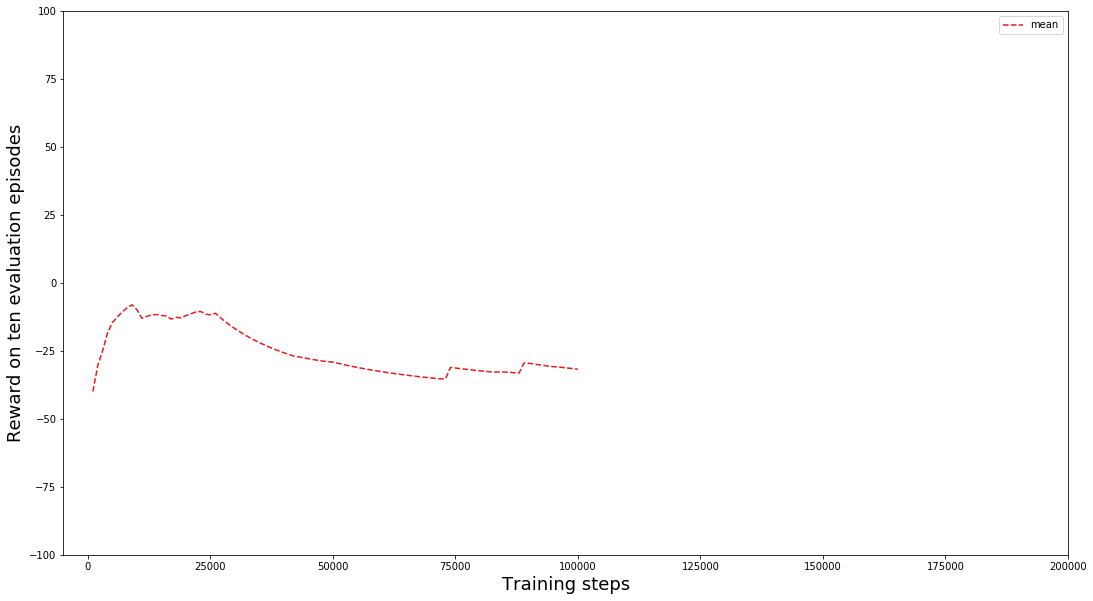

In [4]:
# # Retrieve for each set of parameters the list of runs with final performance over a given threshold. 
# # Can be adapted to filter on different things
# # Store these runs numbers in a dictionary
# dico = {}
# for name, g in expe_res_steps[expe_res_steps['training_step']==199192].groupby('params'):
# #     dico[name] = list(g[g['Test reward on initial goal']>-100]['num_run'].values)
#     dico[name] = list(g['num_run'].values)
#     print(name, dico[name])
    
# # From the dictionary, compute a boolean dataframe, with True at index i if the data at index i of the result dataframe
# # matches the filter. Apply this boolean mask to the results dataframe to retrieve the filtered data
# def in_dico(g):
#     res = g['num_run'] in dico[g['params']]
#     res = (g['num_run'] in [0,1,2,3,4])
#     return res
# mask = expe_res_steps.apply(in_dico, axis=1)
# filtered = expe_res_steps[mask]
filtered = expe_res_steps

# Define the functions for the statistics we want to compute on the dataframe
def quant_inf(x) : return x.quantile(0.1)
def quant_sup(x) : return x.quantile(0.9)
op_dict = {'Test reward on initial goal':[np.mean, np.median, quant_inf,quant_sup]}
columns = ['Test reward on initial goal','training_step','params']

# Apply these functions to the dataframe and store the results in additional columns
stats_eval_init = filtered[columns].groupby(['training_step','params']).agg(op_dict).reset_index()

# Exponentional smoothing of the curve. Increase the ewm parameter for more smoothing.
stats_eval_init_smooth = stats_eval_init[['params','Test reward on initial goal']].groupby('params').apply(lambda x: x.ewm(30).mean())

# Weird bug I had, where the word training caused problems 
stats_eval_init_smooth['trainin_step']=stats_eval_init['training_step']

# Plot the statistics for the results of each set of parameters
fig, ax = plt.subplots(figsize=(18,10))
for i, (name, g) in enumerate(stats_eval_init_smooth.groupby(['params'])):
    params = name.split('_')
#         ax.plot(g['trainin_step'], g['Test reward on initial goal']['mean'], label=name)
#     ax.plot(g['trainin_step'], g['Test reward on initial goal']['median'], label=name, color=colors[i])
    ax.plot(g['trainin_step'], g['Test reward on initial goal']['mean'], color=colors[i], linestyle='dashed')
#     ax.fill_between(g['trainin_step'], 
#                     g['Test reward on initial goal']['quant_inf'], 
#                     g['Test reward on initial goal']['quant_sup'], alpha=0.25, linewidth=0, color=colors[i])
ax.legend()
ax.set_xlabel('Training steps', fontsize=18)
ax.set_ylabel('Reward on ten evaluation episodes', fontsize=18)
ax.set_ylim([-100,100])
ax.set_xlim([-5000,200000])


(-5000, 200000)

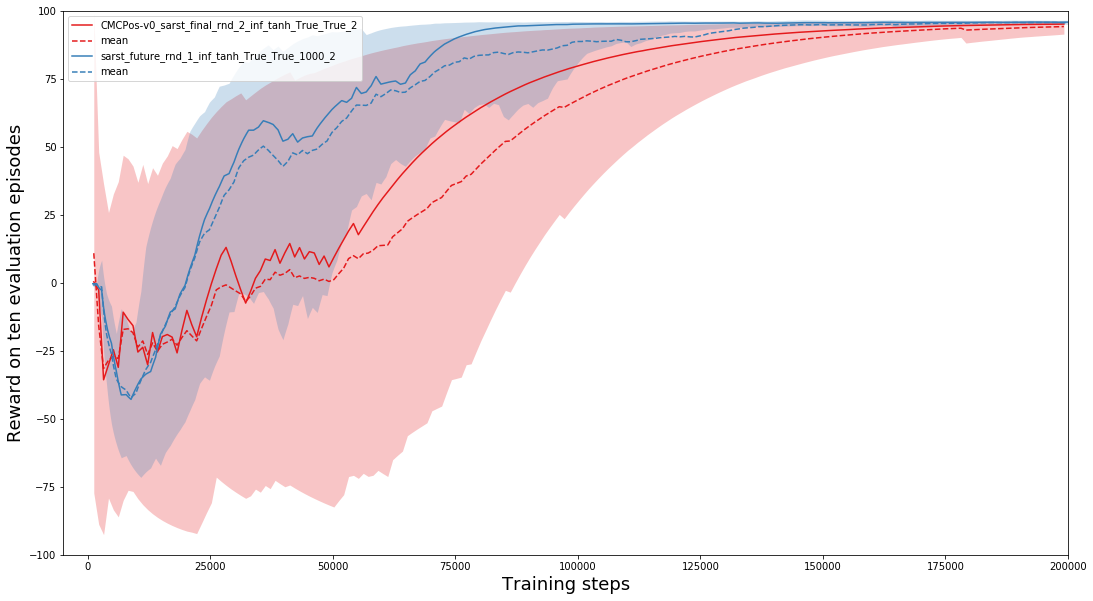

In [31]:
# # Retrieve for each set of parameters the list of runs with final performance over a given threshold. 
# # Can be adapted to filter on different things
# # Store these runs numbers in a dictionary
# dico = {}
# for name, g in expe_res_steps[expe_res_steps['training_step']==199192].groupby('params'):
# #     dico[name] = list(g[g['Test reward on initial goal']>-100]['num_run'].values)
#     dico[name] = list(g['num_run'].values)
#     print(name, dico[name])
    
# # From the dictionary, compute a boolean dataframe, with True at index i if the data at index i of the result dataframe
# # matches the filter. Apply this boolean mask to the results dataframe to retrieve the filtered data
# def in_dico(g):
#     res = g['num_run'] in dico[g['params']]
#     res = (g['num_run'] in [0,1,2,3,4])
#     return res
# mask = expe_res_steps.apply(in_dico, axis=1)
# filtered = expe_res_steps[mask]
filtered = expe_res_steps

# Define the functions for the statistics we want to compute on the dataframe
def quant_inf(x) : return x.quantile(0.1)
def quant_sup(x) : return x.quantile(0.9)
op_dict = {'Test reward on random goal':[np.mean, np.median, quant_inf,quant_sup]}
columns = ['Test reward on random goal','training_step','params']

# Apply these functions to the dataframe and store the results in additional columns
stats_eval_init = filtered[columns].groupby(['training_step','params']).agg(op_dict).reset_index()

# Exponentional smoothing of the curve. Increase the ewm parameter for more smoothing.
stats_eval_init_smooth = stats_eval_init[['params','Test reward on random goal']].groupby('params').apply(lambda x: x.ewm(30).mean())

# Weird bug I had, where the word training caused problems 
stats_eval_init_smooth['trainin_step']=stats_eval_init['training_step']

# Plot the statistics for the results of each set of parameters
fig, ax = plt.subplots(figsize=(18,10))
for i, (name, g) in enumerate(stats_eval_init_smooth.groupby(['params'])):
    params = name.split('_')
#         ax.plot(g['trainin_step'], g['Test reward on initial goal']['mean'], label=name)
    ax.plot(g['trainin_step'], g['Test reward on random goal']['median'], label=name, color=colors[i])
    ax.plot(g['trainin_step'], g['Test reward on random goal']['mean'], color=colors[i], linestyle='dashed')
    ax.fill_between(g['trainin_step'], 
                    g['Test reward on random goal']['quant_inf'], 
                    g['Test reward on random goal']['quant_sup'], alpha=0.25, linewidth=0, color=colors[i])
ax.legend()
ax.set_xlabel('Training steps', fontsize=18)
ax.set_ylabel('Reward on ten evaluation episodes', fontsize=18)
ax.set_ylim([-100,100])
ax.set_xlim([-5000,200000])

In [48]:
import pickle
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as patches
import copy

pickle_dir = '../log/local/CMCPos-v0_sarst_final_rnd_0.1_inf_tanh_True_True_2/2018_03_07_16_04_34/pickle/'
fig = plt.figure()
ax = plt.axes()
plt.ion()
fig.show()

with open(pickle_dir+'video_{:06}.pkl'.format(432),'rb') as handle:
    video = pickle.load(handle)

for i in range(20):
    l = video[i][0]
    p = video[i][1]
    for line in l:
        ax.add_line(lines.Line2D(line[:,0], line[:,1], linewidth=2, color='blue'))
    for patch in p:
        ax.add_patch(patches.Rectangle((patch[0], patch[1]),
                                      patch[3],
                                      patch[2],
                                      fill=True,
                                      facecolor=tuple(patch[4:]),
                                      edgecolor=None,
                                      alpha=0.8))
    plt.pause(0.1)


<IPython.core.display.Javascript object>

TypeError: show() got an unexpected keyword argument 'block'

<a list of 34 Text yticklabel objects>


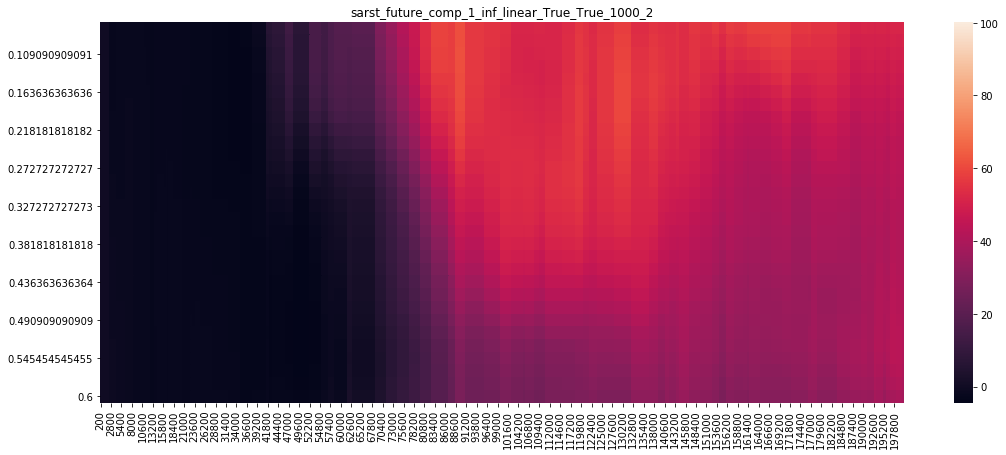

In [51]:
import seaborn as sns
fig, axes = plt.subplots(len(PARAMS), figsize=(18,7))
expe_res_steps_0 = expe_res_steps[(expe_res_steps['num_run']==0)]
# expe_res_steps_0 = expe_res_steps[(expe_res_steps['num_run']==0) & (expe_res_steps['training_step']<=70000)]
for i, (name, g) in enumerate(expe_res_steps_0.groupby('params')):
    q_vals = g['q_values'].apply(pd.Series)
    heatmap = q_vals.T
    heatmap.columns = range(200, 200001,200)
#     heatmap.columns = range(200, 70001,200)
    sns.heatmap(heatmap, ax=axes)
    axes.set_title(name)
    print(axes.get_yticklabels())
    axes.set_ylim([100,70])
    axes.set_yticklabels([list(np.linspace(-1.2, 0.6, 100))[int(label.get_text())] for label in axes.get_yticklabels()])

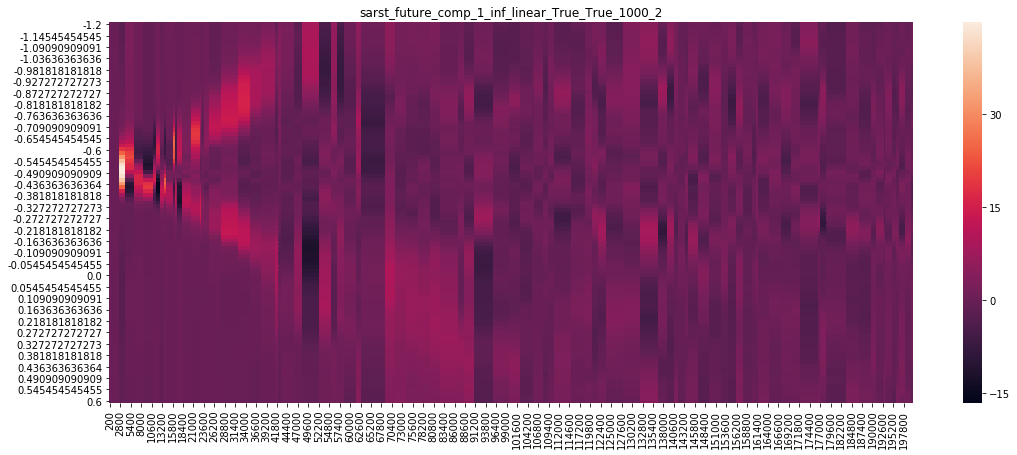

In [42]:
import seaborn as sns
fig, axes = plt.subplots(len(PARAMS), figsize=(18,7))
expe_res_steps_0 = expe_res_steps[(expe_res_steps['num_run']==0)]
# expe_res_steps_0 = expe_res_steps[(expe_res_steps['num_run']==0) & (expe_res_steps['training_step']<=70000)]
for i, (name, g) in enumerate(expe_res_steps_0.groupby('params')):
    q_vals = g['d_q_values'].apply(pd.Series)
    heatmap = q_vals.T
    heatmap.columns = range(200, 200001,200)
#     heatmap.columns = range(200, 70001,200)
    sns.heatmap(heatmap, ax=axes)
    axes.set_title(name)
    axes.set_yticklabels([list(np.linspace(-1.2, 0.6, 100))[int(label.get_text())] for label in axes.get_yticklabels()])
#     axes.set_xlim([0,70000])

In [6]:
frames = [] # List of pandas dataframes corresponding to each results file
for file in files:
    # Fetching json files corresponding to one set of parameters
    res_episodes = glob.glob(file + '/*/' + 'log_episodes/progress.json') 
    for num_run, run in enumerate(res_episodes):
        # Discarding runs with broken result files
        try:
            df = pd.read_json(run, lines=True)
        except ValueError:
            print("run "+run+": invalid")
        df['params'] = file.split('/')[-1]
        df['num_run']=num_run
        frames.append(df)
# Creating the complete dataframe with all dat
expe_res_episodes = pd.concat(frames, ignore_index=True)
expe_res_episodes


,Duration,Episode,Episode steps,Goal,Goal reached,Start,Train reward,Train step,params,num_run
0,0.140558,1,200,"{'dtype': 'float64', '__ndarray__': [-0.076460...",0,"{'dtype': 'float64', '__ndarray__': [0.2086597...",-12.278555,200,ReacherGoal-v0,0
1,2.241972,2,200,"{'dtype': 'float64', '__ndarray__': [0.0236578...",0,"{'dtype': 'float64', '__ndarray__': [0.2088850...",-19.714875,400,ReacherGoal-v0,0
2,4.032290,3,200,"{'dtype': 'float64', '__ndarray__': [-0.071780...",0,"{'dtype': 'float64', '__ndarray__': [0.2079408...",-10.258393,600,ReacherGoal-v0,0
3,5.827963,4,200,"{'dtype': 'float64', '__ndarray__': [0.1226419...",0,"{'dtype': 'float64', '__ndarray__': [0.2095941...",-4.004679,800,ReacherGoal-v0,0
4,7.627367,5,200,"{'dtype': 'float64', '__ndarray__': [-0.165636...",0,"{'dtype': 'float64', '__ndarray__': [0.2094965...",-15.702573,1000,ReacherGoal-v0,0
5,9.813469,6,200,"{'dtype': 'float64', '__ndarray__': [-0.035567...",0,"{'dtype': 'float64', '__ndarray__': [0.2098713...",-30.042254,1200,ReacherGoal-v0,0
6,11.618163,7,200,"{'dtype': 'float64', '__ndarray__': [-0.091397...",0,"{'dtype': 'float64', '__ndarray__': [0.2086826...",-36.611103,1400,ReacherGoal-v0,0
7,13.424264,8,200,"{'dtype': 'float64', '__ndarray__': [0.0732861...",0,"{'dtype': 'float64', '__ndarray__': [0.2090634...",-33.735901,1600,ReacherGoal-v0,0
8,15.218889,9,200,"{'dtype': 'float64', '__ndarray__': [0.1302345...",0,"{'dtype': 'float64', '__ndarray__': [0.2098382...",-26.970171,1800,ReacherGoal-v0,0
9,17.010424,10,200,"{'dtype': 'float64', '__ndarray__': [-0.031576...",0,"{'dtype': 'float64', '__ndarray__': [0.2094595...",-13.820901,2000,ReacherGoal-v0,0


(-5000, 200000)

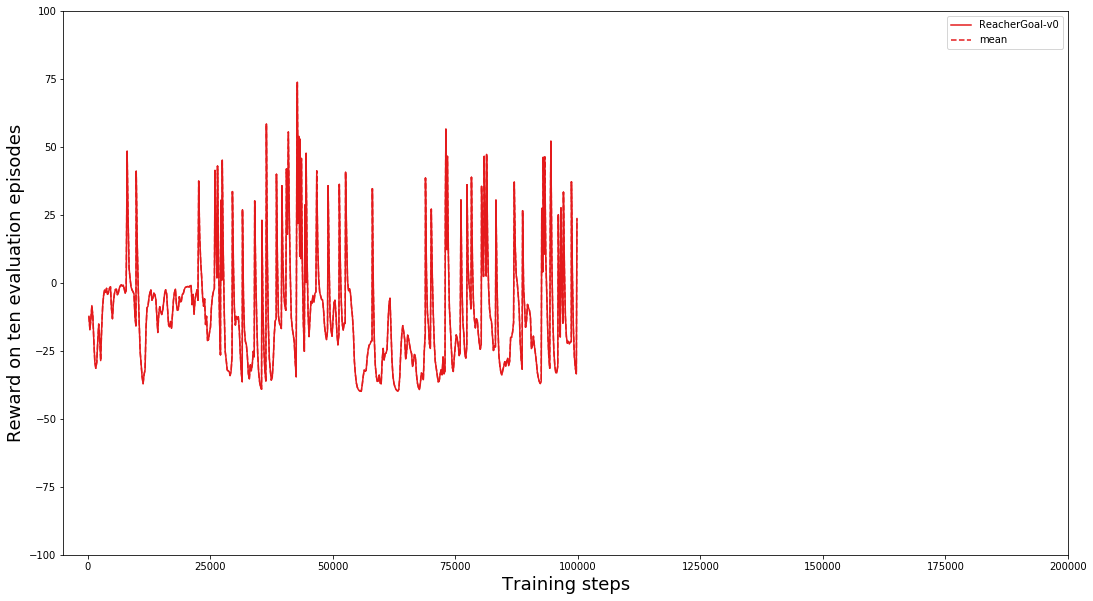

In [8]:
filtered = expe_res_episodes


# Define the functions for the statistics we want to compute on the dataframe
def quant_inf(x) : return x.quantile(0.1)
def quant_sup(x) : return x.quantile(0.9)
op_dict = {'Train reward':[np.mean, np.median, quant_inf,quant_sup]}
columns = ['Train reward','Train step','params']

# Apply these functions to the dataframe and store the results in additional columns
stats_eval_init = filtered[columns].groupby(['Train step','params']).agg(op_dict).reset_index()

# Exponentional smoothing of the curve. Increase the ewm parameter for more smoothing.
stats_eval_init_smooth = stats_eval_init[['params','Train reward']].groupby('params').apply(lambda x: x.ewm(1).mean())

# Weird bug I had, where the word training caused problems 
stats_eval_init_smooth['trainin_step']=stats_eval_init['Train step']

# Plot the statistics for the results of each set of parameters
fig, ax = plt.subplots(figsize=(18,10))
for i, (name, g) in enumerate(stats_eval_init_smooth.groupby(['params'])):
    params = name.split('_')
#         ax.plot(g['trainin_step'], g['Test reward on initial goal']['mean'], label=name)
    ax.plot(g['trainin_step'], g['Train reward']['median'], label=name, color=colors[i])
    ax.plot(g['trainin_step'], g['Train reward']['mean'], color=colors[i], linestyle='dashed')
    ax.fill_between(g['trainin_step'], 
                    g['Train reward']['quant_inf'], 
                    g['Train reward']['quant_sup'], alpha=0.25, linewidth=0, color=colors[i])
ax.legend()
ax.set_xlabel('Training steps', fontsize=18)
ax.set_ylabel('Reward on ten evaluation episodes', fontsize=18)
ax.set_ylim([-100,100])
ax.set_xlim([-5000,200000])

In [16]:
filtered['Goal'].apply(lambda x: x['__ndarray__'][0])

0     -0.076460
1      0.023658
2     -0.071780
3      0.122642
4     -0.165637
5     -0.035567
6     -0.091398
7      0.073286
8      0.130235
9     -0.031577
10    -0.179324
11     0.183360
12    -0.081028
13    -0.063668
14    -0.194540
15    -0.100922
16     0.023055
17     0.172475
18    -0.009799
19     0.017234
20     0.181190
21    -0.087846
22    -0.073625
23    -0.103254
24     0.008567
25    -0.126243
26     0.034565
27    -0.041092
28     0.112329
29     0.193603
         ...   
496    0.126263
497   -0.150484
498   -0.135426
499    0.057397
500   -0.198601
501   -0.161630
502   -0.161989
503   -0.162352
504    0.135012
505   -0.021608
506    0.029497
507   -0.048712
508    0.157486
509    0.106922
510    0.026461
511   -0.122469
512    0.186942
513   -0.144312
514   -0.034044
515    0.091967
516    0.188224
517    0.195797
518    0.040760
519    0.192752
520    0.046147
521   -0.004053
522   -0.127914
523   -0.088700
524   -0.008522
525    0.119112
Name: Goal, Length: 526,

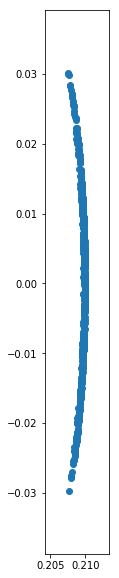

In [19]:
fig, ax = plt.subplots(figsize=(18,10))
plt.gca().set_aspect('equal', adjustable='box')
ax.scatter(filtered['Start'].apply(lambda x: x['__ndarray__'][0]), filtered['Start'].apply(lambda x: x['__ndarray__'][1]))